# Transfer Learning For Computer Vision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## Load data

In [5]:
# data augmentation and normalization for training
# just normalization for validation
data_transform={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir='data/hymenoptera_data'
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transform[x]) for x in ['train','val']}
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}
dataset_sizes={x:len(image_datasets[x]) for x in ['train','val']}
class_names=image_datasets['train'].classes

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

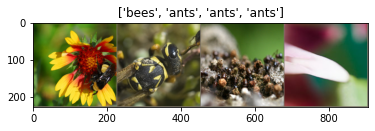

In [7]:
def imshow(inp,title=None):
    """Imshow for Tensor"""
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# Get a batch of training data
inputs,classes=next(iter(dataloaders['train']))

# Make a grid from batch
out=torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])

## Training the model

In [13]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since=time.time()
    
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            running_loss=0.0
            running_corrects=0
            
            # Iterate over data
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs) #torch.Size([batch_size, classes])
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase=='train':
                scheduler.step()

            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            # deep copy the model
            if phase=='val' and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                    
        print()
    
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [9]:
def visualize_model(model,num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)
            
            for j in range(inputs.size()[0]): #the size of minibatch
                images_so_far+=1
                ax=plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [10]:
model_ft=models.resnet18(pretrained=True)
print(model_ft)
print(model_ft.fc)
num_ftrs=model_ft.fc.in_features
# Here the size of each output sample is set to 2
# Alternatively, it can be generalized to nn.Linear(num_ftrs,len(class_name))
model_ft.fc=nn.Linear(num_ftrs,2)

model_ft=model_ft.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nishiyama/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [11]:
print(model_ft.fc)

Linear(in_features=512, out_features=2, bias=True)


## Train and evaluate

In [14]:
model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4919 Acc: 0.7541
val Loss: 0.2625 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4107 Acc: 0.8566
val Loss: 0.3009 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5529 Acc: 0.7787
val Loss: 0.2446 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.6272 Acc: 0.7541
val Loss: 0.5482 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5748 Acc: 0.7787
val Loss: 0.5886 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.5748 Acc: 0.7910
val Loss: 0.3018 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3543 Acc: 0.8484
val Loss: 0.3086 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3181 Acc: 0.8566
val Loss: 0.2965 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3069 Acc: 0.8566
val Loss: 0.2671 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3154 Acc: 0.8730
val Loss: 0.2576 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2910 Acc: 0.8770
val Loss: 0.2198 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3001 Acc: 0.8689
val Loss: 0.2267 Acc: 0.9150

Ep

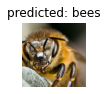

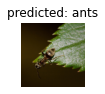

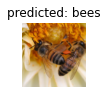

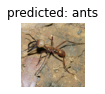

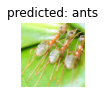

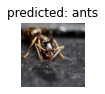

In [15]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [17]:
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False
    
# Parameters of newly constructd modules have requires_grad=True by default
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)

model_conv=model_conv.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

In [18]:
model_conv=train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5727 Acc: 0.6926
val Loss: 0.2517 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4378 Acc: 0.8033
val Loss: 0.4212 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.4713 Acc: 0.7828
val Loss: 0.2360 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3817 Acc: 0.8484
val Loss: 0.2584 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5050 Acc: 0.7623
val Loss: 0.1994 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5557 Acc: 0.7746
val Loss: 0.3067 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4117 Acc: 0.8074
val Loss: 0.3092 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3255 Acc: 0.8607
val Loss: 0.2082 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3979 Acc: 0.8279
val Loss: 0.1988 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4416 Acc: 0.8197
val Loss: 0.2067 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3441 Acc: 0.8402
val Loss: 0.2049 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3381 Acc: 0.8525
val Loss: 0.2033 Acc: 0.9412

Ep

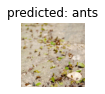

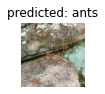

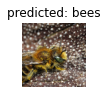

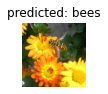

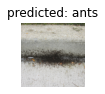

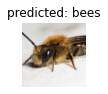

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()